In [19]:
# Imports and initial setup
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
# Spotify authentication
client_credentials = SpotifyClientCredentials(client_id='97a92c7614f248d38952612def032c31', 
                                              client_secret='51f8eaebb63042678edbaf3d3a52f82c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials)

In [21]:
# Function to get track features from Spotify
def get_track_features(track_id):
    features = sp.audio_features([track_id])[0]
    if features is not None:
        # Additional features added: tempo, speechiness, liveness
        return [features['danceability'], features['energy'], features['valence'], 
                features['acousticness'], features['tempo'], features['speechiness'], features['liveness']]
    return None

# Get track IDs for a specific mood
def get_tracks_for_mood(mood):
    results = sp.search(q=mood, type='track', limit=50)
    track_ids = [track['id'] for track in results['tracks']['items']]
    return track_ids


In [22]:
# Initialize lists to hold data
X = []
y = []

# Example moods to search for
moods = ['happy', 'sad', 'relaxed', 'energetic']

# Fetch features for each mood
for mood in moods:
    track_ids = get_tracks_for_mood(mood)
    for track_id in track_ids:
        features = get_track_features(track_id)
        if features:
            X.append(features)
            y.append(mood)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert target labels to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [23]:
# Data augmentation function
def augment_data(X, y, n_augment=2):
    X_augmented = []
    y_augmented = []
    for i in range(len(X)):
        for _ in range(n_augment):
            noise = np.random.normal(0, 0.01, X[i].shape)  # Small random noise
            X_augmented.append(X[i] + noise)
            y_augmented.append(y[i])
    return np.array(X_augmented), np.array(y_augmented)

# Apply data augmentation
X_augmented, y_augmented = augment_data(X, y)
X_combined = np.vstack((X, X_augmented))
y_combined = np.concatenate((y, y_augmented))

In [37]:
# Split the augmented data into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Encode y_temp and y_test after data splitting
# y_train = le.transform(y_train)
# y_val = le.transform(y_val)
# y_test = le.transform(y_test)

In [38]:
# Define the neural network with regularization but without built-in early stopping
mlp = MLPClassifier(
    hidden_layer_sizes=(20, 10),
    max_iter=2000,
    alpha=0.01,
    learning_rate_init=0.001,
    random_state=42
)

# Custom training loop with manual early stopping
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 10  # Number of epochs to wait for improvement before stopping
patience_counter = 0

for epoch in range(2000):
    mlp.partial_fit(X_train, y_train, classes=le.classes_)  # Use original class labels (strings)
    
    if epoch % 100 == 0:
        train_loss = mlp.loss_
        train_losses.append(round(train_loss, 4))
        
        # Calculate validation loss, using integer encoding for indexing only
        val_loss = np.mean(1 - mlp.predict_proba(X_val)[np.arange(len(y_val)), le.transform(y_val)])  # Transform y_val to integer indices
        val_losses.append(round(val_loss, 4))
        print(f"Epoch [{epoch}/2000], Train Loss: {train_loss}, Val Loss: {val_loss}")
        
        # Manual early stopping: check if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter if improvement
        else:
            patience_counter += 1  # Increment if no improvement
            
        # Stop if validation loss has not improved for 'patience' epochs
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch [0/2000], Train Loss: 1.5202880589095489, Val Loss: 0.7379567317039967
Epoch [100/2000], Train Loss: 1.0043272186690935, Val Loss: 0.5900363049474372
Epoch [200/2000], Train Loss: 0.7853583843927171, Val Loss: 0.5173507713759875
Epoch [300/2000], Train Loss: 0.6353441104379256, Val Loss: 0.4673057524884545
Epoch [400/2000], Train Loss: 0.5254944776880599, Val Loss: 0.42680552980208875
Epoch [500/2000], Train Loss: 0.45009772616435584, Val Loss: 0.39553103638984455
Epoch [600/2000], Train Loss: 0.38665928227589064, Val Loss: 0.36225985842636266
Epoch [700/2000], Train Loss: 0.33315821525156053, Val Loss: 0.3340460493846073
Epoch [800/2000], Train Loss: 0.28795550327810576, Val Loss: 0.3087975435000841
Epoch [900/2000], Train Loss: 0.24642127472551387, Val Loss: 0.2861456765298944
Epoch [1000/2000], Train Loss: 0.20977993784432186, Val Loss: 0.2631314416839523
Epoch [1100/2000], Train Loss: 0.17817295390043947, Val Loss: 0.2434522443828761
Epoch [1200/2000], Train Loss: 0.150294212

MLP Test Accuracy: 0.9328

MLP Classification Report:
               precision    recall  f1-score   support

   energetic       1.00      0.94      0.97        35
       happy       0.92      0.88      0.90        26
     relaxed       1.00      0.86      0.92        21
         sad       0.86      1.00      0.93        37

    accuracy                           0.93       119
   macro avg       0.95      0.92      0.93       119
weighted avg       0.94      0.93      0.93       119



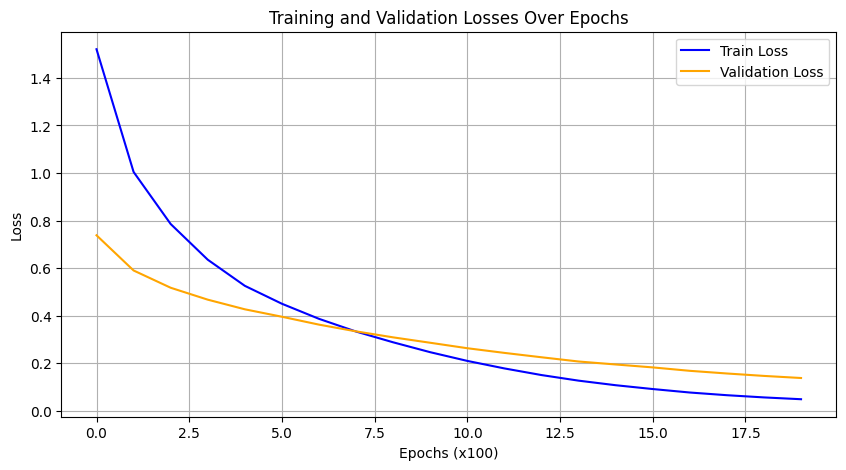

In [39]:
# Evaluate the MLP model on the test set
y_pred_mlp = mlp.predict(X_test)
test_accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Test Accuracy: {test_accuracy_mlp:.4f}")
print("\nMLP Classification Report:\n", classification_report(y_test, y_pred_mlp, target_names=le.classes_))

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs (x100)')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()
